### Cross Entropy Benchmarking

In [1]:
"""
Cross entropy benchmarking of two qubits (XEB) is a method for characterizing the fidelity of a two-qubit gate.
The XEB sequence consists of a random sequence of single-qubit gates and a two-qubit gate, followed by a measurement.
The sequence is repeated many times, and the results are used to calculate the cross entropy between the ideal and measured states.
The cross entropy is a measure of the distance between two probability distributions, and is related to the fidelity of the two-qubit gate.
The cross entropy is calculated as follows:
    1. The ideal state is calculated by applying the sequence of single-qubit gates and the two-qubit gate to the initial state |00>.
    2. The measured state is calculated by applying the sequence of single-qubit gates to the initial state |00>, followed by a measurement.
    3. The cross entropy is calculated between the ideal and measured states.
The cross entropy is calculated for a range of sequence depths, and the results are used to calculate the fidelity of the two-qubit gate.
In this script, we provide an example of how to run an XEB sequence on the OPX.

Author: Arthur Strauss - Quantum Machines
Created: 16/01/2024 (Last modified: 16/01/2024)
"""
import numpy as np
import pandas as pd
import seaborn as sns
from qm import QuantumMachinesManager
from qm.qua import *
from qm.simulate.credentials import create_credentials
from scipy.optimize import curve_fit

import sys
sys.path.append('/Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/Configurations')

from configuration import *
from qm.simulate import SimulationConfig
from matplotlib import pyplot as plt
import pprint
from macros import multiplexed_readout, qua_declaration, cz_gate
from qiskit import QuantumCircuit
from qiskit.circuit.library import CZGate, RXGate, RYGate, RZGate, HGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate
from qiskit.quantum_info import Statevector
from time import sleep
from scipy.linalg import sqrtm
import warnings

import os, fnmatch

%matplotlib inline


2024-02-29 14:55:07,723 - qm - INFO     - Starting session: 5a56ef85-8171-478d-ac41-87a7755f739d
Absolute Path: /Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/5-Flux-Tunable-Transmons/Standard Configuration
QPU q1 control frequency: 3075461000 Hz
QPU q2 control frequency: 3860908000 Hz
QPU q3 control frequency: 3004488000 Hz
QPU q4 control frequency: 3596207000 Hz
QPU q5 control frequency: 4472389000 Hz


### Setting parameters:

In [59]:
qubits = [5] # |00> = |q5,q4> |q4=0> = 10 + 00
apply_cz = False
seqs = 57  # 101 # Number of random sequences to run per depth
max_depth = 180  # 7  # Max depth of the XEB sequence
step = 2  # Step for the depth iteration
avgs = 280  # 101  # Number of averages per sequence
depths = np.arange(1, max_depth+1, step)  # Create an array of depths to iterate through
gate_set_choice = 2  # Choose the gate-set: 1, 2, 3 or 4
impose_0_cycle = True

time_per_point = 16/(420*20*37) # in min
print(f"Estimated runtime: {seqs*avgs*len(depths)*time_per_point} minutes")
real_time = seqs*avgs*len(depths)*thermalization_time + seqs*avgs*(depths[0]+depths[-1])*(len(depths)//2)*pi_len
print("real-time: %s minutes"%(real_time*1e-9/60))

save_notebook_dir = save_dir.parents[6]/"data"


Estimated runtime: 73.94594594594595 minutes
real-time: 6.20697168 minutes


### Selecting & Loading data:

In [4]:
flist = fnmatch.filter(os.listdir(save_notebook_dir), 'XEB*')
keyword = ""
flist = list(filter(lambda x: keyword in x, flist))
print("Saved data with keyword '%s':\n" %keyword)
for i, f in enumerate(flist): print("%s. %s" %(i,f))


Saved data with keyword '':

0. XEB_q4_5_s(42)_d(10)_g(2)_cz(1)_0cyc(1).npz
1. XEB_q4_5_s(420)_d(20)_g(2)_cz(1)_0cyc(1).npz
2. XEB_q4_5_s(420)_d(100)_g(2)_cz(1)_0cyc(1).npz
3. XEB_q4_5_s(420)_d(100)_g(2)_cz(0)_0cyc(1).npz
4. XEB_q4_5_s(42)_d(20)_g(2)_cz(1)_0cyc(1).npz
5. XEB_q4_5_s(142)_d(20)_g(2)_cz(1)_0cyc(1).npz
6. XEB_q4_5_s(420)_d(250)_g(2)_cz(0)_0cyc(1).npz
7. XEB_q4_5_s(42)_d(30)_g(2)_cz(0)_0cyc(1).npz
8. XEB_q5_s(420)_d(100)_g(2)_cz(0)_0cyc(1).npz
9. XEB_q4_s(420)_d(100)_g(2)_cz(0)_0cyc(1).npz


In [15]:
# Loading selected data:
filename = flist[8]
npz_file = np.load(save_notebook_dir/f"{filename}", allow_pickle=True)

# Create an empty dictionary to store variables
variables = {}

# Iterate through keys and store variables in the dictionary
for key in npz_file.files: variables[key] = npz_file[key]

# Close the npz file after loading the data
npz_file.close()

# loading variables from file:
g = variables['g']
a = variables['a']
quadratures = variables['quadratures']
state = variables['state']
# counts = variables['counts'][()]
counts = variables['counts'].item()
gate_set_choice = variables['gate_set_choice']
seqs = variables['seqs']
max_depth = variables['max_depth']
step = variables['step']
depths = np.arange(1, max_depth+1, step)
avgs = variables['avgs']
qubits = variables['qubits']
apply_cz = variables['apply_cz']
impose_0_cycle = variables['impose_0_cycle']

print("qubits = %s" %qubits)
print("seqs = %s" %seqs)
print("max_depth = %s" %max_depth)
print("step = %s" %step)
print("avgs = %s" %avgs)
print("apply_cz = %s" %apply_cz)
print("impose_0_cycle = %s" %impose_0_cycle)
print("gate_set_choice = %s" %gate_set_choice)

print(counts)


qubits = [5]
seqs = 420
max_depth = 100
step = 5
avgs = 57
apply_cz = False
impose_0_cycle = True
gate_set_choice = 2
{'0': array([[18, 22, 20, ..., 30, 29, 44],
       [14,  4, 18, ..., 35, 36, 35],
       [16,  7, 10, ..., 24, 19, 37],
       ...,
       [14, 28, 31, ..., 34, 18, 33],
       [13, 21, 11, ..., 31, 20, 23],
       [18,  9, 11, ..., 35, 31, 40]]), '1': array([[39, 35, 37, ..., 27, 28, 13],
       [43, 53, 39, ..., 22, 21, 22],
       [41, 50, 47, ..., 33, 38, 20],
       ...,
       [43, 29, 26, ..., 23, 39, 24],
       [44, 36, 46, ..., 26, 37, 34],
       [39, 48, 46, ..., 22, 26, 17]])}


### Derivations from set / loaded parameters

In [62]:
# For QUA & Simulation:
qubits = list(qubits)
qubits_el = [f"q{i}_xy" for i in qubits]
n_qubits = len(qubits)
dim = 2 ** n_qubits
multiplexed = qubits + [x+1 for x in range(5) if (x+1) not in qubits]
print(f"multiplexed: {multiplexed}")

cz_type = "const_wf"
if n_qubits < 2:
    apply_cz = False
    print("CZ gate not applied (less than 2 qubits)")

# For Data Saving:
qubits_involved = '_'.join([str(x) for x in qubits])
comment = f"s({seqs})_d({max_depth})_g({gate_set_choice})_cz({int(apply_cz)})_0cyc({int(impose_0_cycle)})"
filename = f"XEB_q{qubits_involved}_{comment}"

print(f"qubits involved: {qubits_involved}")

multiplexed: [5, 1, 2, 3, 4]
CZ gate not applied (less than 2 qubits)
qubits involved: 5


### Define Unitary & Amplitude Matrix

In [64]:
# Random gates
X90, Y90, Z180 = RXGate(np.pi / 2), RYGate(np.pi / 2), RZGate(np.pi)
Z45 = RZGate(1 * np.pi / 4)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix() + Y.to_matrix())/np.sqrt(2), label='W')
# SW = UnitaryGate(sqrtm(W), label='SW')
SW = UnitaryGate(np.array([[1, -np.sqrt(1j)], [np.sqrt(-1j), 1]])/np.sqrt(2), label='SW') # from Supremacy paper

XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
# XY90 = UnitaryGate((T.to_matrix() @ X90.to_matrix()), label="XY90")
# XY90 = UnitaryGate((X90.to_matrix() @ T.to_matrix()), label="XY90")

XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ, CP = CZGate(), CPhaseGate(np.pi/2)

X90_dict = {"gate": X90, 'amp_matrix': np.array([1., 0., 0., 1.])}
# Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., 1., -1., 0.])}
Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., -1., 1., 0.])} # verified w/ CX
# XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., 1., -1., 1.])}
XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])} # verified w/ CX

# TODO: For the dicts below, need to check the validity of amplitude matrices!
XY90mm_dict = {"gate": XY90mm, 'amp_matrix': 0.70710678 * np.array([-1., -1., 1., -1.])}
XY90pm_dict = {"gate": XY90pm, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}
XY90mp_dict = {"gate": XY90mp, 'amp_matrix': 0.70710678 * np.array([-1., 1., -1., 1.])}
T_dict = {"gate": T, 'amp_matrix': np.array([1., 0., 0., 1])}  # No actual need for amp_matrix,
# but here for consistency with the current workflow
SW_dict = {"gate": SW, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}  # Amp matrix similar to XY90 # verified w/ CX

# Possible gate sets
gate_dict1 = {0: X90_dict, 1: Y90_dict, 2: T_dict}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90_dict, 1: Y90_dict, 2: SW_dict}  # Supremacy gate set (https://www.nature.com/articles/s41586-019-1666-5)
gate_dict3 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict, 3: XY90mm_dict, 4: XY90pm_dict, 5: XY90mp_dict}  # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict}  # Currently used in the QM XEB example (XY90==XY90pp)
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Gate set choice:
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)
print("gate_dict: %s" %gate_dict)


gate_dict: {0: {'gate': Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), 'amp_matrix': array([1., 0., 0., 1.])}, 1: {'gate': Instruction(name='ry', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), 'amp_matrix': array([ 0., -1.,  1.,  0.])}, 2: {'gate': Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[ 0.70710678+0.j , -0.5       -0.5j],
       [ 0.5       -0.5j,  0.70710678+0.j ]])]), 'amp_matrix': array([ 0.70710678, -0.70710678,  0.70710678,  0.70710678])}}


In [65]:
# Check Unitary:
from qiskit.quantum_info import Operator

Operator(XY90).is_unitary()
print("Check Identity: ")
print(XY90.to_matrix()@XY90.to_matrix().conjugate().transpose())


Check Identity: 
[[ 1.0000000e+00-9.95716912e-18j -9.7278522e-18-9.72785220e-18j]
 [-9.7278522e-18+9.72785220e-18j  1.0000000e+00+9.95716912e-18j]]


### Running QUA

In [66]:
qmm = QuantumMachinesManager(host=qop_ip, port=qop_port, cluster_name=cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(host="tyler-263ed49e.dev.quantum-machines.co", port=443, credentials=create_credentials())
# qubits = ["q0", "q1"]  # Fix which qubits to use on the chip (quantum elements in the configuration)
# readout_elements = ["rr0", "rr1"]  # Fix which readout resonators to use on the chip (readout elements in the
# configuration)
# ge_threshold = 0.1  # Threshold for the ground state population (used for the readout)
# thermalization_time = 100  # Thermalization time for the qubits (in ns)
simulate = False

def assign_amplitude_matrix(gate, a):
    """
    QUA Macro for assigning the amplitude matrix arguments for a given gate index.
    :param gate: Gate index
    :param a: Amplitude matrix arguments
    """
    with switch_(gate):
        for i in range(random_gates):
            with case_(i):
                for j in range(4):
                    assign(a[j], gate_dict[i]['amp_matrix'][j])


# QUA Program

with program() as xeb:
    # Declare QUA variables
    I, I_st, Q, Q_st, n, n_st = qua_declaration(nb_of_qubits=len(multiplexed))
    # I, Q = [declare(fixed) for _ in range(2)], [declare(fixed) for _ in range(2)]
    s, tot_state_ = declare(int), declare(int)
    d, d_ = declare(int), declare(int)
    g = [declare(int, size=max_depth) for _ in range(n_qubits)]  # Gate indices list for both qubits
    a = [[declare(fixed, size=max_depth) for _ in range(4)] for _ in
         range(n_qubits)]  # Amplitude matrices for both qubits (for all depths)
    counts = [declare(int, value=0) for _ in range(dim)] # Counts for the 4 possible states
    state = [declare(bool) for _ in range(len(multiplexed))] # State of the qubits
    # Declare streams
    # I_st, Q_st = [declare_stream() for _ in range(2)], [declare_stream() for _ in range(2)]
    s_st = declare_stream()
    counts_st = [declare_stream() for _ in range(dim)]
    state_st = [declare_stream() for _ in range(len(multiplexed))]
    g_st = [declare_stream() for _ in range(n_qubits)]

    # Randomize the random number generator
    r = Random()
    r.set_seed(12321)
    # r.set_seed(11111)

    # If we are simulating, we need to update the frequency of the qubits to 0 to visualize the sequence
    # if simulate:
    if True:
        a_st = [[declare_stream() for _ in range(4)] for _ in range(n_qubits)]
        # for qubit in qubits_el:
            # update_frequency(qubit, 0)

    # Generate and run the XEB sequences
    with for_(s, 0, s < seqs, s + 1):
        with for_each_(d, depths): # max-depths
            # Randomize the sequence of single-qubit gates
            # NOTE: different from Google: randomizing for each growing-depths and sequences
            with for_(d_, 0, d_ < d, d_ + 1):
                for q in range(n_qubits):
                    with if_(d_ == 0):
                        if impose_0_cycle: assign(g[q][d_], r.rand_int(random_gates-1)) # to ensure 0-cycle isn't repeated on the 1-cycle
                        else: assign(g[q][d_], r.rand_int(random_gates))
                    with if_(d_ > 0):
                        assign(g[q][d_], r.rand_int(random_gates))
                        with while_(g[q][d_] == g[q][d_ - 1]):  # Make sure the same gate is not applied twice in a row
                            assign(g[q][d_], r.rand_int(random_gates))
                    # Map the sequence indices into amplitude matrix arguments (each index corresponds to a random gate)
                    assign_amplitude_matrix(g[q][d_], [a[q][i][d_] for i in range(4)])
                    save(g[q][d_], g_st[q])

                    # if simulate:
                    if True:
                        for amp_matrix_element in range(4):
                            save(a[q][amp_matrix_element][d_], a_st[q][amp_matrix_element])

            # Run the XEB sequence
            with for_(n, 0, n < avgs, n + 1):
                # save(n, n_st)
                # Reset the qubits to their ground states (here simple wait but could be an active reset macro)
                if simulate:
                    wait(25, *qubits_el)
                else:
                    wait(3 * thermalization_time, *qubits_el)

                # NOTE: imposing first gate at 0-cycle:
                if impose_0_cycle:
                    for q in range(n_qubits): 
                        play("x90" * amp(*SW_dict["amp_matrix"]), qubits_el[q])
                        # play("y90", qubits_el[q])
                        # play("x180", qubits_el[q])

                # Play all cycles generated for sequence s of depth d
                with for_(d_, 0, d_ < d, d_ + 1):
                    for q in range(n_qubits):  # Play single qubit gates on both qubits
                        if T_dict in gate_dict.values():
                            with switch_(g[q][d_], unsafe=True):
                                for j in range(2):
                                    with case_(j):
                                        play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                                with case_(2):
                                    frame_rotation(np.pi/4, qubits_el[q])
                        elif SW_dict in gate_dict.values():
                            # raise NotImplementedError("SW gate not readily implemented yet")
                            # warnings.warn("SW gate not readily implemented yet")
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                        else:
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                    align()
                    if apply_cz:
                        # Insert your two-qubit gate macro here
                        cz_gate(qubits[0], qubits[1], cz_type)
                        frame_rotation_2pi(eval(f"cz{5}_{4}_2pi_dev"), "q5_xy")
                        frame_rotation_2pi(eval(f"cz{4}_{5}_2pi_dev"), "q4_xy")
                    align()

                # Measure the state (insert your readout macro here)
                multiplexed_readout(I, I_st, Q, Q_st, resonators=multiplexed, weights="rotated_")

                # State discrimination
                assign(state[0], I[0] > eval(f"ge_threshold_q{multiplexed[0]}"))
                assign(state[1], I[1] > eval(f"ge_threshold_q{multiplexed[1]}"))
                save(state[0], state_st[0])
                save(state[1], state_st[1])

                # State Estimation: returned as an integer, to be later converted to bitstrings
                for q in range(n_qubits):
                    assign(tot_state_, tot_state_ + 2**q * Cast.to_int(state[q]))

                # assign(tot_state_, Cast.to_int(state[0]) + 2 * Cast.to_int(state[1]))
                # assign(tot_state_, Cast.to_int(state[1]) + 2 * Cast.to_int(state[0]))
                with switch_(tot_state_):
                    for i in range(dim):  # Bitstring conversion
                        with case_(i):
                            assign(counts[i], counts[i] + 1)  # counts for 00, 01, 10 and 11
                assign(tot_state_, 0)
            for i in range(dim):  # Resetting Bitstring collection
                save(counts[i], counts_st[i])
                assign(counts[i], 0)

            # Save the sequence iteration to get the progress bar
            save(s, s_st)

    # Save the results
    with stream_processing():
        s_st.save("s")
        for q in range(n_qubits):
            g_st[q].save_all(f"g{q}")
            I_st[q].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"I{q}")
            Q_st[q].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"Q{q}")
            state_st[q].boolean_to_int().buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(
                f"state{q}")
        for i in range(dim):
            string = "s" + bin(i)[2:].zfill(n_qubits)
            counts_st[i].buffer(len(depths)).save_all(string)

        # if simulate:
        if True:
            for q in range(n_qubits):
                for d_ in range(4):
                    a_st[q][d_].save_all(f"a{q + 1}_{bin(d_)[2:].zfill(2)}")

if simulate:
    job = qmm.simulate(config, xeb, SimulationConfig(15000))
    job.get_simulated_samples().con1.plot()
    job.get_simulated_samples().con2.plot()
    plt.show()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(xeb)

job.result_handles.wait_for_all_values()
result = job.result_handles
g = [result.get(f"g{i}").fetch_all()['value'] for i in range(n_qubits)]

if simulate:
    a = {f"a{q + 1}_{bin(i)[2:].zfill(2)}": result.get(f"a{q + 1}_{bin(i)[2:].zfill(2)}").fetch_all()['value'] for q in
         range(n_qubits) for i in range(4)}
else:
    a = {f"a{q + 1}_{bin(i)[2:].zfill(2)}": result.get(f"a{q + 1}_{bin(i)[2:].zfill(2)}").fetch_all()['value'] for q in
     range(n_qubits) for i in range(4)}
    quadratures = {f"I{i}": result.get(f"I{i}").fetch_all()['value'] for i in range(n_qubits)}
    quadratures.update({f"Q{i}": result.get(f"Q{i}").fetch_all()['value'] for i in range(n_qubits)})
    
    state = {f"state{i}": result.get(f"state{i}").fetch_all()['value'] for i in range(n_qubits)}
    counts = {bin(i)[2:].zfill(n_qubits): result.get(f"s{bin(i)[2:].zfill(n_qubits)}").fetch_all()['value'] for i in range(dim)}
    # state1, state2 = [result.get(f'state{i}').fetch_all()['value'] for i in [1, 2]]
    # state00, state01, state10, state11 = [result.get(f's{bin(i)[2:].zfill(2)}').fetch_all()['value'] for
    #                                       i in
    #                                       range(4)]
    # 
    # print(f"state1:\n {state1}, state2:\n {state2}")
    # print(f"state00:\n {state00}, state01:\n {state01}, state10:\n {state10}, state11:\n {state11}")


    # Close the quantum machines at the end in order to put all flux biases to 0 so that the fridge doesn't heat-up
    qm.close()

    

2024-02-29 16:53:33,675 - qm - INFO     - Performing health check
2024-02-29 16:53:33,689 - qm - INFO     - Health check passed
2024-02-29 16:53:34,878 - qm - INFO     - Sending program to QOP for compilation
2024-02-29 16:53:35,701 - qm - INFO     - Executing program


### Saving Data

In [68]:
# Data saving:
np.savez(save_notebook_dir/filename, g=g, a=a, quadratures=quadratures, state=state, counts=counts, 
            gate_set_choice=gate_set_choice, seqs=seqs, max_depth=max_depth, step=step, avgs=avgs, qubits=qubits,
            apply_cz=apply_cz, impose_0_cycle=impose_0_cycle)
print("Data saved as %s.npz" %filename)

Data saved as XEB_q5_s(57)_d(180)_g(2)_cz(0)_0cyc(1).npz


### Post-processing

In [69]:
# Rebuild gate sequences generated from the QUA:
print("n_qubits: %s" %n_qubits)

sq_indices = []
idx = 0
for s in range(seqs):
    sq_indices.append([])
    for i, d in enumerate(depths):
        sq_indices[s].append(np.zeros((n_qubits, d), dtype=int))
        for d_ in range(d):
            for q in range(n_qubits):
                sq_indices[s][i][q][d_] = g[q][idx]
            idx += 1


def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

records = []
incoherent_distribution = np.ones(dim) / (dim)
expected_probs = np.zeros((seqs, len(depths), dim))
measured_probs = np.zeros((seqs, len(depths), dim))
fidelities = np.zeros((seqs, len(depths)))


# Reconstruct every Circuit from the previously rebuilt gate sequences: (using Qiskit)
circuits_list = []
singularity = []
outlier = []
for s in range(seqs):
    circuits_list.append([])
    for d_, d in enumerate(depths):
        state = Statevector.from_int(0, dim)
        qc = QuantumCircuit(n_qubits)

        # NOTE: imposing first gate at 0-cycle:
        gate_cycle_0 = SW # XY90, H
        if impose_0_cycle:
            for i in range(n_qubits):
                qc.append(gate_cycle_0, [i]) 
                # qc.append(gate_cycle_0, [1])

        for k in range(d):
            sq_gates = [gate_dict[sq_indices[s][d_][q][k]]["gate"] for q in range(n_qubits)]
            for q in range(n_qubits):
                qc.append(sq_gates[q], [q])

            if apply_cz: 
                qc.append(CZ, [0, 1])

        circuits_list[s].append(qc)
        expected_probs[s, d_] = np.round(Statevector(qc).probabilities(), 5) # [1, 0]
        measured_probs[s, d_] = np.array([counts[bin(i)[2:].zfill(n_qubits)][s][d_] for i in range(dim)]) / avgs

        xe_incoherent = cross_entropy(incoherent_distribution, expected_probs[s, d_])
        xe_measured = cross_entropy(measured_probs[s, d_], expected_probs[s, d_])
        xe_expected = cross_entropy(expected_probs[s, d_], expected_probs[s, d_])

        f_xeb = ((xe_incoherent - xe_measured) / (xe_incoherent - xe_expected))
        if np.isinf(f_xeb) or np.isnan(f_xeb):
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
            singularity.append((s, d_))
            fidelities[s, d_] = np.nan  # Set all singularities to NaN
        elif f_xeb < 0 or f_xeb > 1:
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
            outlier.append((s, d_))
            fidelities[s, d_] = np.nan  # Set all outliers to NaN
        else:
            fidelities[s, d_] = f_xeb
            pass
            # print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            # print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")        
        
            records += [
            {
                "sequence": s,
                "depth": depths[d_],
                "pure_probs": expected_probs[s, d_],
                "sampled_probs": measured_probs[s, d_],
                "circuit": circuits_list[s][d_],
            }
        ]
        
print(f"singularities: {singularity}")
print(f"overall singularities: {len(singularity)/seqs/len(depths)*100}%")
print(f"outliers: {outlier}")
print(f"overall outliers: {len(outlier)/seqs/len(depths)*100}%")

for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / dim
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)


n_qubits: 1
seq 1, depth 25: f_xeb = -0.7117944337675036
<<xe>>: xe_incoherent: 0.696380048707357, xe_measured: 0.7009773707039813, xe_expected: 0.6899212710342995
seq 1, depth 109: f_xeb = -0.7552363050483327
<<xe>>: xe_incoherent: 0.6967830755064719, xe_measured: 0.7022683488930074, xe_expected: 0.6895200859628423
seq 1, depth 133: f_xeb = -0.12921232168696117
<<xe>>: xe_incoherent: 0.6946774591252372, xe_measured: 0.6950727192189786, xe_expected: 0.6916184622077524
seq 1, depth 169: f_xeb = -0.15471892728210065
<<xe>>: xe_incoherent: 0.7028314888061931, xe_measured: 0.7058185441226481, xe_expected: 0.6835251546108382
seq 2, depth 3: f_xeb = -0.04877668084442278
<<xe>>: xe_incoherent: 0.703986156405087, xe_measured: 0.7050397311522554, xe_expected: 0.68238618836854
seq 2, depth 19: f_xeb = 1.059199630243038
<<xe>>: xe_incoherent: 0.8035304987679002, xe_measured: 0.5779292980316902, xe_expected: 0.5905383542328376
seq 2, depth 25: f_xeb = 1.0307153164296037
<<xe>>: xe_incoherent: 0.70

### Inspecting Singularities

In [ ]:
# # Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
for s, d_ in singularity:
    print(s, d_)
    print(circuits_list[s][d_])
# circuits_list[223][1].draw("mpl", style="clifford")

In [46]:
for s, d_ in singularity:
    print(expected_probs[s, d_])

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


### Check Gate Sequences history

In [ ]:
check_amp_matrix = 0
idx = 0
print("seqs: %s, depths: %s" %(seqs, depths))
for s in range(seqs):
    for id, d in enumerate(depths):
        print("circuit of seqs-%s, depths-%s:\n %s" %(s+1, d, circuits_list[s][id]))
        if check_amp_matrix:
            for d_ in range(d):
                print(f"cycle-{d_+1}")
                for q in range(n_qubits):
                    print(f'a{q+1}:\n')
                    print([a[f"a{q+1}_{bin(i)[2:].zfill(2)}"][idx] for i in range(4)])
                idx += 1

### Plotting Speckles from counts

<0> Measured
data: [[0.26785714 0.78571429 0.55       ... 0.60357143 0.53571429 0.40714286]
 [0.22142857 0.49642857 0.63571429 ... 0.50357143 0.25357143 0.68214286]
 [0.23214286 0.79285714 0.51071429 ... 0.34285714 0.525      0.62857143]
 ...
 [0.31785714 0.79285714 0.36428571 ... 0.32857143 0.69642857 0.31428571]
 [0.26071429 0.49642857 0.58571429 ... 0.575      0.63214286 0.37857143]
 [0.26428571 0.525      0.675      ... 0.48214286 0.47857143 0.39285714]]
241
<0> Expected
data: [[0.14645 0.92678 0.625   ... 0.99154 0.60095 0.38315]
 [0.14645 0.57322 0.75    ... 0.52415 0.00952 0.96448]
 [0.14645 0.92678 0.625   ... 0.05423 0.63035 0.97035]
 ...
 [0.14645 0.92678 0.375   ... 0.20575 0.98582 0.12119]
 [0.14645 0.57322 0.75    ... 0.83698 0.88965 0.27928]
 [0.14645 0.57322 0.75    ... 0.55647 0.46591 0.41816]]
242
<1> Measured
data: [[0.73214286 0.21428571 0.45       ... 0.39642857 0.46428571 0.59285714]
 [0.77857143 0.50357143 0.36428571 ... 0.49642857 0.74642857 0.31785714]
 [0.76785

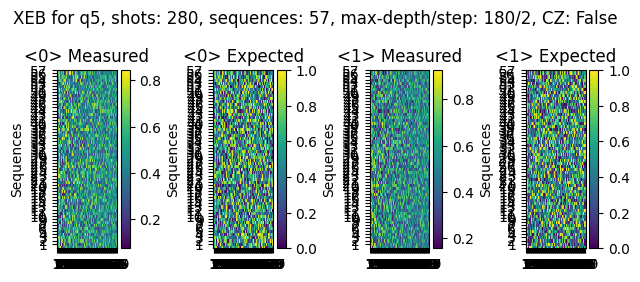

In [70]:
# Plot the results
def create_subplot(data, subplot_number, title):
    print(title)
    print("data: %s" % data)
    print(subplot_number)
    plt.subplot(subplot_number)
    # plt.pcolor(depths, range(seqs), np.abs(data), vmin=0., vmax=1.)
    plt.pcolor(depths, range(seqs), np.abs(data))
    ax = plt.gca()
    ax.set_title(title)
    if subplot_number > 244: ax.set_xlabel('Circuit depth')
    ax.set_ylabel('Sequences')
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, seqs + 1))
    plt.colorbar()


titles, data = [], []
for i in range(dim):
    titles.append(f"<{bin(i)[2:].zfill(n_qubits)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(n_qubits)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):
    plt.suptitle(f"XEB for q"+ qubits_involved +f", shots: {avgs}, sequences: {seqs}, max-depth/step: {max_depth}/{step}, CZ: {apply_cz}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=0.1, hspace=0.7)
    k+=1

    plt.tight_layout()
    plt.ion()


### Google fXEB estimation

In [71]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df


,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,"[0.14645, 0.85355]","[0.26785714285714285, 0.7321428571428571]","((Instruction(name='unitary', num_qubits=1, nu...",0.749995,0.5,0.664148,0.164148,0.249995,0.041036,0.062498
1,0,3,"[0.92678, 0.07322]","[0.7857142857142857, 0.21428571428571427]","((Instruction(name='unitary', num_qubits=1, nu...",0.864282,0.5,0.743874,0.243874,0.364282,0.088839,0.132702
2,0,5,"[0.625, 0.375]","[0.55, 0.45]","((Instruction(name='unitary', num_qubits=1, nu...",0.531250,0.5,0.512500,0.012500,0.031250,0.000391,0.000977
3,0,7,"[0.02145, 0.97855]","[0.11785714285714285, 0.8821428571428571]","((Instruction(name='unitary', num_qubits=1, nu...",0.958020,0.5,0.865749,0.365749,0.458020,0.167520,0.209783
4,0,9,"[0.9375, 0.0625]","[0.75, 0.25]","((Instruction(name='unitary', num_qubits=1, nu...",0.882812,0.5,0.718750,0.218750,0.382812,0.083740,0.146545
...,...,...,...,...,...,...,...,...,...,...,...,...
4397,56,161,"[0.01794, 0.98206]","[0.31785714285714284, 0.6821428571428572]","((Instruction(name='unitary', num_qubits=1, nu...",0.964764,0.5,0.675608,0.175608,0.464764,0.081616,0.216005
4398,56,165,"[0.03496, 0.96504]","[0.30714285714285716, 0.6928571428571428]","((Instruction(name='unitary', num_qubits=1, nu...",0.932524,0.5,0.679373,0.179373,0.432524,0.077583,0.187077
4399,56,169,"[0.96959, 0.03041]","[0.6142857142857143, 0.38571428571428573]","((Instruction(name='unitary', num_qubits=1, nu...",0.941030,0.5,0.607335,0.107335,0.441030,0.047338,0.194507
4400,56,171,"[0.16, 0.84]","[0.2857142857142857, 0.7142857142857143]","((Instruction(name='unitary', num_qubits=1, nu...",0.731200,0.5,0.645714,0.145714,0.231200,0.033689,0.053453


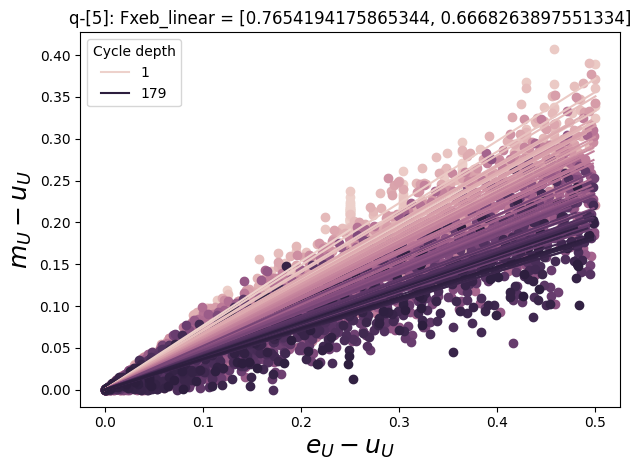

In [72]:
colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.title("q-%s: Fxeb_linear = %s" %(qubits, [fids["fidelity"][x] for x in [0, 1]]))
plt.tight_layout()


### Plotting fXEB curve

a: 0.713207762307173, b: 3.199399424063054e-13
mask_log: 90
mask: 90
depths: [0.76541942 0.65073968 0.62462379 0.73489267 0.64596846 0.69178036
 0.66694912 0.60352574 0.65865016 0.65547866 0.60313619 0.63058508
 0.63576067 0.64450434 0.60978003 0.64490133 0.60761961 0.62743376
 0.58792586 0.58704349 0.61782545 0.59926488 0.50461948 0.56488021
 0.55994333 0.56221424 0.55481082 0.54470689 0.51975864 0.54502304
 0.55310465 0.55154476 0.54373052 0.58680791 0.5549919  0.5375452
 0.51020817 0.53637586 0.52652198 0.50421176 0.5305799  0.5564583
 0.51860757 0.47168806 0.49226735 0.53430756 0.46665831 0.50194616
 0.45411856 0.49480541 0.49669103 0.43509084 0.49403786 0.47496267
 0.47097695 0.4271573  0.4756024  0.44686304 0.47271358 0.47459585
 0.47308537 0.45816981 0.40755278 0.48733507 0.484907   0.44246942
 0.42972051 0.46717043 0.43986714 0.44736698 0.40680761 0.41573749
 0.41580965 0.43163131 0.46806306 0.42537094 0.41993862 0.41151173
 0.38698252 0.37643177 0.44607118 0.39607027 0.4026431

/var/folders/lz/657q9ypj0pd6l1g7f0wk81hm0000gn/T/ipykernel_11368/3749151156.py:50: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, _, _, _ = stats.linregress(masked_cycle_depths, log_fidelities)


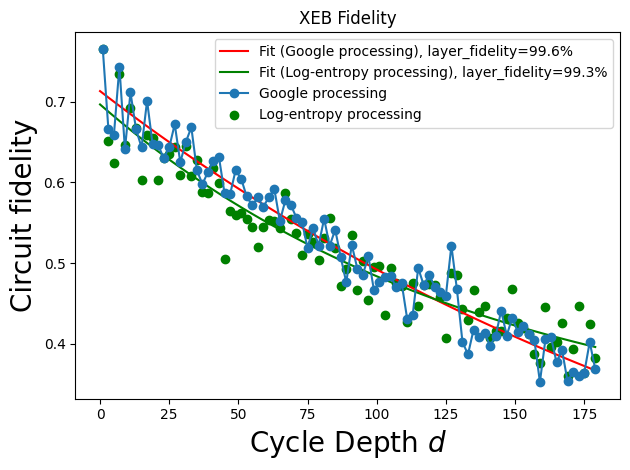

In [73]:
from scipy.stats import stats
from scipy import optimize

plot_log_XEB = 1

# Fit the data
# def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float) -> np.ndarray:
def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float, b: float) -> np.ndarray:
    """An exponential decay for fitting.

    This computes `a * layer_fid**cycle_depths`

    Args:
        cycle_depths: The various depths at which fidelity was estimated. This is the independent
            variable in the exponential function.
        a: A scale parameter in the exponential function.
        layer_fid: The base of the exponent in the exponential function.
    """
    # return a * layer_fid**cycle_depths
    return a * layer_fid**cycle_depths + b

def _fit_exponential_decay(
    cycle_depths: np.ndarray, fidelities: np.ndarray
) -> Tuple[float, float, float, float]:
    """Fit an exponential model fidelity = a * layer_fid**x using nonlinear least squares.

    This uses `exponential_decay` as the function to fit with parameters `a` and `layer_fid`.

    Args:
        cycle_depths: The various depths at which fidelity was estimated. Each element is `x`
            in the fit expression.
        fidelities: The estimated fidelities for each cycle depth. Each element is `fidelity`
            in the fit expression.

    Returns:
        a: The first fit parameter that scales the exponential function, perhaps accounting for
            state prep and measurement (SPAM) error.
        layer_fid: The second fit parameters which serves as the base of the exponential.
        a_std: The standard deviation of the `a` parameter estimate.
        layer_fid_std: The standard deviation of the `layer_fid` parameter estimate.
    """
    cycle_depths = np.asarray(cycle_depths)
    fidelities = np.asarray(fidelities)
    mask = (fidelities > 0) & (fidelities < 1)
    masked_cycle_depths = cycle_depths[mask]
    masked_fidelities = fidelities[mask]
    
    log_fidelities = np.log(masked_fidelities)

    slope, intercept, _, _, _ = stats.linregress(masked_cycle_depths, log_fidelities)
    layer_fid_0 = np.clip(np.exp(slope), 0, 1)
    a_0 = np.clip(np.exp(intercept), 0, 1)
    b_0 = 1

    try:
        # (a, layer_fid), pcov = optimize.curve_fit(
        (a, layer_fid, b), pcov = optimize.curve_fit(
            exponential_decay,
            masked_cycle_depths,
            masked_fidelities,
            # p0=(a_0, layer_fid_0),
            p0=(a_0, layer_fid_0, b_0),
            # bounds=((0, 0), (1, 1)),
            bounds=((0, 0, 0), (1, 1, 1)),
            nan_policy='omit'
        )
    except ValueError:  # pragma: no cover
        return 0, 0, np.inf, np.inf

    # a_std, layer_fid_std = np.sqrt(np.diag(pcov))
    a_std, layer_fid_std, b_std = np.sqrt(np.diag(pcov))
    # return a, layer_fid, a_std, layer_fid_std
    return a, layer_fid, a_std, layer_fid_std, b, b_std

fit_google = True
fit_log_entropy = True
xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    # a, layer_fid, a_std, layer_fid_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    a, layer_fid, a_std, layer_fid_std, b, b_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    # plt.plot(xx, exponential_decay(xx, a, layer_fid),
    plt.plot(xx, exponential_decay(xx, a, layer_fid, b),
         label='Fit (Google processing), layer_fidelity={:.1f}%'.format(layer_fid*100),
         color='red')
    print(f"a: {a}, b: {b}")
except:
    raise
    print("Fit for Google processing data failed")
    fit_google = False
Fxeb = np.nanmean(fidelities, axis=0)
try:
    # a2, layer_fid2, a_std2, layer_fid_std2 = _fit_exponential_decay(depths, Fxeb)
    a2, layer_fid2, a_std2, layer_fid_std2, b2, b_std2 = _fit_exponential_decay(depths, Fxeb)
    if plot_log_XEB:
        # plt.plot(xx, exponential_decay(xx, a2, layer_fid2),
        plt.plot(xx, exponential_decay(xx, a2, layer_fid2, b2),
            label="Fit (Log-entropy processing), layer_fidelity={:.1f}%".format(layer_fid2*100),
            color="green")
    
except:
    raise
    print("Fit for Log-entropy processing data failed")
    fit_log_entropy = False

mask = (fids["fidelity"] > 0) & (fids["fidelity"] < 1)    
google_depths = fids["depth"][mask]
google_fids =  fids["fidelity"][mask]   
plt.plot(google_depths, google_fids, marker="o", label="Google processing")

mask_log = (Fxeb > 0) & (Fxeb < 1)

print("mask_log: %s" %len(mask_log))
print("mask: %s" %len(mask))
print("depths: %s" %Fxeb)

if plot_log_XEB:
    plt.scatter(depths[mask_log], Fxeb[mask_log], marker = 'o', color='green', label="Log-entropy processing")

plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title("XEB Fidelity")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [ ]:
if fit_google:
    print("Google processing fit:")
    print("Params: ", a, layer_fid)
    print("layer-fidelity: ", layer_fid)
if fit_log_entropy:
    print("Log-entropy processing fit:")
    print("Params: ", a2, layer_fid2)
    print("layer-fidelity: ", layer_fid2)

In [ ]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

In [ ]:
print("relative difference", np.abs(fids["fidelity"] - Fxeb))

In [ ]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
